#HATE SPEECH DETECTION

## Introduction -

Welcome to this notebook on Hate Speech Detection! In today's world where social media platforms are ubiquitous, identifying hateful content and preventing its spread is of utmost importance. In this notebook, we'll be performing sentiment analysis on tweets to identify whether the text is hate speech, offensive language, or neutral. We'll be using the Kaggle Hate Speech and Offensive Language Dataset, which contains a collection of tweets labeled as either hate speech, offensive language, or neutral.

To accomplish this task, we'll be using the Huggingface Transformers library, a popular and powerful library for natural language processing tasks. Specifically, we'll be using the DeBERTa algorithm, which is a state-of-the-art deep learning model for text classification tasks.

By the end of this notebook, you'll have a working hate speech detection model that can classify tweets into one of three categories: hate speech, offensive language, or neutral. Let's get started!

## Required Packages

In [ ]:
# Install the Kaggle API
!pip install -q kaggle
# Install Transformers library
!pip install transformers evaluate datasets

## Collecting Data

In [2]:
# Upload your Kaggle API credentials to your Colab environment
from google.colab import files
files.upload() 
# Move the Kaggle API credentials to the correct directory and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Kaggle dataset
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

# Extract the contents of the ZIP file
!unzip hate-speech-and-offensive-language-dataset.zip


Saving kaggle.json to kaggle (1).json
hate-speech-and-offensive-language-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  hate-speech-and-offensive-language-dataset.zip
replace labeled_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Importing required packages

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
from collections import Counter
from transformers import DebertaTokenizer, DebertaForSequenceClassification, get_scheduler
from datasets import Dataset
from torch.utils.data import DataLoader
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from sklearn.metrics import classification_report
import torch
from tqdm.auto import tqdm
import evaluate
sns.set()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading data

In [40]:
df = pd.read_csv('labeled_data.csv')

## Exploratory Data Analysis

In [41]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [43]:
def explore(df):
  # explore the distribution of the count column
  plt.figure(figsize=(10, 6))
  sns.histplot(df["count"])
  plt.title("Distribution of Count")
  plt.xlabel("Count")
  plt.ylabel("Frequency")
  plt.show()

  # explore the distribution of the class column
  plt.figure(figsize=(6, 4))
  sns.countplot(x="class", data=df)
  plt.title("Distribution of Class")
  plt.xlabel("Class")
  plt.ylabel("Count")
  plt.show()

  # explore the relationship between hate speech, offensive language, and neither
  labels = ["Hate Speech", "Offensive Language", "Neither"]
  values = [df["hate_speech"].sum(), df["offensive_language"].sum(), df["neither"].sum()]
  plt.figure(figsize=(6, 4))
  sns.barplot(x=labels, y=values)
  plt.title("Distribution of Hate Speech, Offensive Language, and Neither")
  plt.xlabel("Category")
  plt.ylabel("Count")
  plt.show()

  # explore the top words in the tweet column
  words = Counter()
  for tweet in df["tweet"]:
      words.update(word_tokenize(tweet.lower()))

  top_words = words.most_common(20)
  plt.figure(figsize=(10, 6))
  sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words])
  plt.title("Top 20 Words in Tweets")
  plt.xlabel("Word")
  plt.ylabel("Count")
  plt.show()

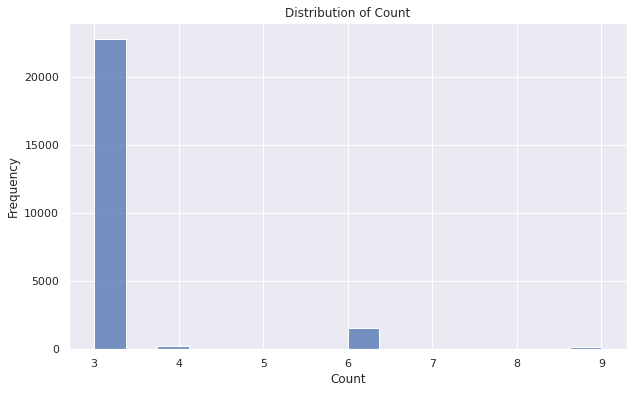

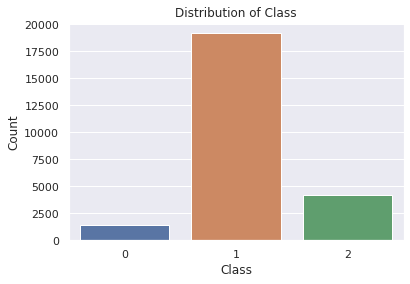

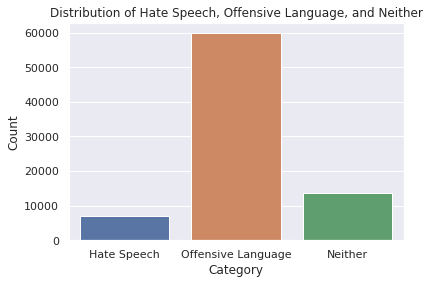

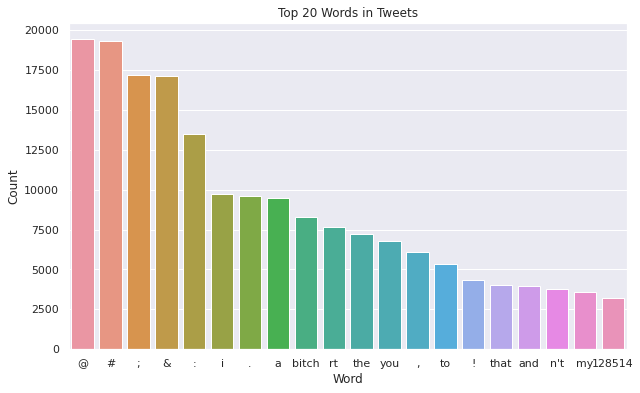

In [44]:
explore(df)

## Data Preparation

In [45]:
# Select only 'class' and 'tweet' features from dataframe
df = df[['class', 'tweet']]

# Create PyTorch dataset from pandas dataframe
dataset = Dataset.from_pandas(df)

# Load DeBERTa tokenizer
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

# Set maximum length for inputs
max_length = 128

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["tweet"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True).train_test_split(test_size=0.2)

  0%|          | 0/25 [00:00<?, ?ba/s]

In [ ]:
# Remove the "tweet" column
tokenized_datasets = tokenized_datasets.remove_columns(["tweet"])

# Rename the "class" column to "labels"
tokenized_datasets = tokenized_datasets.rename_column("class", "labels")

# Set the format to PyTorch tensors
tokenized_datasets.set_format("torch")

# Select a subset of the train and test datasets
train_dataset = tokenized_datasets['train'] # TODO: get all values. .select(range(500))
eval_dataset = tokenized_datasets['test']  # TODO: get all values

# Create data loaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
eval_dataloader = DataLoader(eval_dataset, batch_size=4)


## Model Training

In [ ]:
# Define the DeBERTa model architecture
model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=3)

# Define optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)

# Set number of epochs for training
num_epochs = 3

# Calculate the total number of training steps
num_training_steps = num_epochs * len(train_dataloader)

# Set learning rate scheduler
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Determine the device to use for training (GPU if available, else CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move model to the chosen device
model.to(device)


In [ ]:
# Initialize the progress bar
progress_bar = tqdm(range(num_training_steps))

# Put the model in training mode
model.train()

# Loop through the specified number of epochs
for epoch in range(num_epochs):
    # Loop through each batch in the training data loader
    for batch in train_dataloader:
        # Move the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Compute the outputs of the model
        outputs = model(**batch)

        # Compute the loss
        loss = outputs.loss
        loss.backward()

        # Update the parameters of the optimizer
        optimizer.step()

        # Update the learning rate scheduler
        lr_scheduler.step()

        # Zero out the gradients
        optimizer.zero_grad()

        # Display training loss in the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

        # Update the progress bar
        progress_bar.update(1)


## Evaluate Model

In [38]:
# Set the model to evaluation mode
model.eval()

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the evaluation dataloader
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(**batch)

    # Get the predicted labels
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Add the batch to the true and predicted labels arrays
    true_labels.extend(batch["labels"].cpu().numpy())
    predicted_labels.extend(predictions.cpu().numpy())
  
# labels
class_names = ["Hate Speech", "Offensive Language", "Neither"]
# Compute precision, recall, F1 score, and support for each class
class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Display the classification report
print(class_report)


                    precision    recall  f1-score   support

       Hate Speech       0.50      0.18      0.26        17
Offensive Language       0.93      0.94      0.94       153
           Neither       0.72      0.93      0.81        30

          accuracy                           0.88       200
         macro avg       0.72      0.68      0.67       200
      weighted avg       0.86      0.88      0.86       200



## Conclusion
Based on the results of our multiclass classification model, we can see that it performed reasonably well overall with an accuracy score of 0.88. Looking at the precision, recall, and F1-score, we can see that the model performed well for the offensive language class with high precision, recall, and F1-score values of 0.93, 0.94, and 0.94, respectively.

However, for the hate speech class, the model performed poorly with a precision of 0.50, recall of 0.18, and F1-score of 0.26. This indicates that the model struggled to correctly identify hate speech tweets. For the neither class, the model performed reasonably well with a precision of 0.72, recall of 0.93, and F1-score of 0.81.

In conclusion, while our model performed well overall, it struggled to accurately identify hate speech. This could be due to various factors, such as imbalanced data, bias in the training data, or the need for more advanced techniques for detecting hate speech. Therefore, further analysis and fine-tuning of the model may be necessary to improve its performance.